In [16]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# shape (381109, 11)
data_1 = pd.read_csv('datasets/d1.csv')
# data_1 = data_1.drop(['id'], axis=1)

data_2 = pd.read_csv('datasets/d2.csv')

In [18]:
data_1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [19]:
data_1.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

<AxesSubplot:>

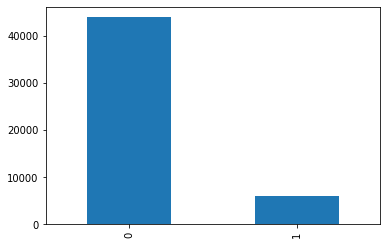

In [20]:
data_1 = data_1.sample(50000)
data_1['Response'].value_counts().plot(kind='bar')

In [21]:
# Scaleing is a process of transforming data into a stander values so we can get the best of it
# 
# https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
scaler =  StandardScaler()
scaled_column_names = ['Vintage','Annual_Premium']
data_cluster = data_1[scaled_column_names].copy()
scaled_data = scaler.fit_transform(data_cluster)

data_scaled = data_1.copy()
data_scaled[scaled_column_names] = scaled_data
data_scaled

# [['Vintage','Annual_Premium']]
# scaler.inverse_transform([[0.748795	, 0.574539]])

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
346909,346910,Male,27,1,5.0,1,< 1 Year,No,-1.630074,152.0,1.494471,0
259980,259981,Male,51,1,41.0,0,1-2 Year,Yes,0.098358,26.0,-1.225239,1
291152,291153,Female,48,1,28.0,0,> 2 Years,Yes,-0.326804,155.0,1.076972,0
371287,371288,Male,30,1,7.0,0,< 1 Year,No,-1.630074,1.0,1.375186,0
34626,34627,Female,27,1,41.0,1,< 1 Year,No,-0.296219,152.0,1.709185,0
...,...,...,...,...,...,...,...,...,...,...,...,...
285663,285664,Male,22,1,29.0,1,< 1 Year,No,0.224027,152.0,1.267829,0
336966,336967,Female,45,1,15.0,1,1-2 Year,No,0.222568,26.0,0.683330,0
132514,132515,Female,25,1,47.0,1,< 1 Year,No,-1.630074,152.0,0.456687,0
60755,60756,Male,56,1,34.0,0,1-2 Year,Yes,0.107814,26.0,-0.223240,0


In [22]:
%%time

clustering = DBSCAN(eps=3, min_samples=2).fit(scaled_data)
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

In [1]:
# data = data_1.sample(5000)

le = LabelEncoder()
encoder_dict = dict()
data_endocded = data_scaled.copy()

for col in data_endocded:
    if col not in ['Annual_Premium', 'Vintage']:
        le = le.fit(data_endocded[col])
        data_endocded[col] = le.transform(data_endocded[col])
        encoder_dict[col] = le

np.save('FILE_NAME.npy', encoder_dict)
# encoder_dict = np.load('FILE_NAME.npy', allow_pickle=True).tolist()
data_endocded.head()

NameError: name 'LabelEncoder' is not defined

In [128]:
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16])

In [133]:
data['nn'] = clustering.labels_
data.head(1000)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,nn
35908,0,32,1,14,0,0,1,2630.0,20,164,0,-1
145602,1,31,1,46,0,0,1,2630.0,52,179,0,-1
179137,0,19,1,46,0,0,1,2630.0,20,228,1,-1
186933,1,3,1,50,1,1,0,2630.0,69,167,0,-1
95818,1,7,1,3,1,1,0,2630.0,69,143,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
235870,1,41,1,30,1,0,0,20819.0,69,31,0,-1
274441,1,0,1,25,1,1,0,20857.0,76,85,0,-1
240344,0,35,1,3,1,0,0,20861.0,49,211,0,-1
53718,0,58,1,28,0,0,1,20891.0,52,92,0,-1
